# Data Preprocessing

### This notebook walks through the process of preparing a single region  & zone of imagrey and polygon labels to be used in a deep learning model

The high level steps are as follows:
1. Create tile cells over the extent of the zone
2. Subset these tiles into training and validation sets
3. Clip the aerial imagery to the tiles
4. Clip the polygon labels to the corresponding aerial imgagery tiles
5. Bun the polygons into rasterize mask tiles
6. Save the final image tiles and mask tiles in relative directories



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rio_tiler import main as rt_main
import mercantile
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from matplotlib import pyplot as plt
import numpy as np


In [3]:
from src.utilities import processing as proc
from src.visualization import visualization as vis

/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/brentsair/anaconda3/envs

In [4]:
#set the file paths for the first selected COG and labels:
region = 'mon'
zone = '207cc7'
train_directory = 'train_tier_1'

# load geojson for labels
label_gdf, geotif =proc.import_data(zone = zone, region = region, train_tier = train_directory)

# geojson = f'../../data/raw/{train_directory}/{region}/{zone}-labels/{zone}.geojson'
# geotif = f'../../data/raw/{train_directory}/{region}/{zone}/{zone}.tif'

In [5]:
# #make the directories to store processed/output data
img_path, mask_path = proc.make_processed_directories(zone = zone, region = region)

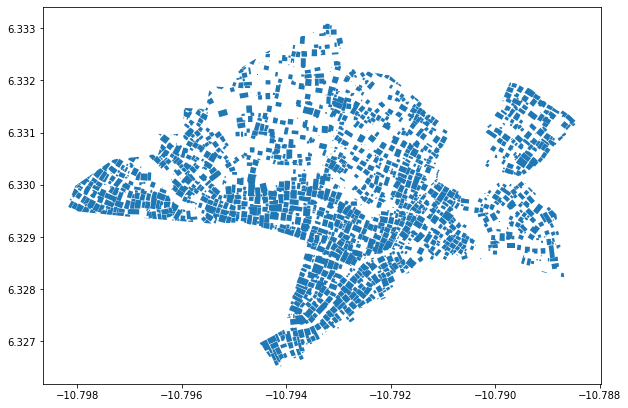

In [6]:
#visualize the label polygons
label_gdf.plot(figsize=(10,10))

### Creat training and validation subsets of the geometry

We need the polygons and the geotif imagery to be clipped into small tiles in order to be processes and eventually fed into a a CNN. To begin with we need to take the following steps:

1. Using supermercado tile burn method to create square polygon "cells" representing all the slippy map tiles at a specified zoom level that overlap the labeled polygons. 
2. Then we seperate these cells into training and validation sets. 


### Methodology and strategy for splitting: 
Originally I was splitting the training and validation set based on the bounds. I would seperate the extent into 20/80 slplit. I had a hunch that this type of split could lead to variance senstivity in my model. If intead the validation cells are sprinkled throughout the entire region, it will more randomly train the model and prevent sensitivity to geographic interdependencies.



In [7]:
#define the tile size and zoom level for the burned tiles
zoom_level = 19

In [8]:
#Use the supermercado burn tiles method to create a new geojson with slippy tiles 
proc.burn_tiles(region = region, zone = zone, zoom_level= zoom_level)

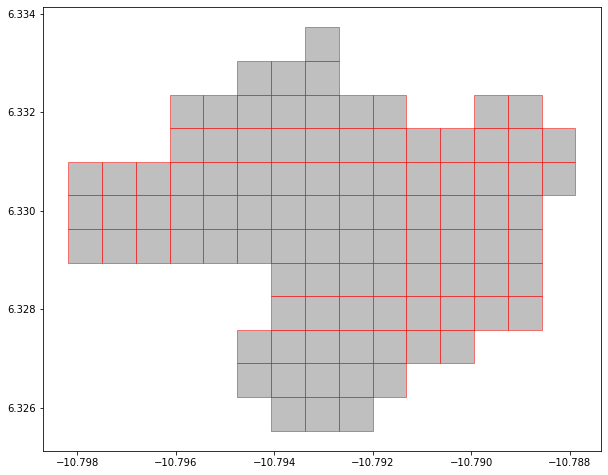

In [9]:
tiles_df = proc.load_tile_geojson(region = region, zone = zone, visualize=True)

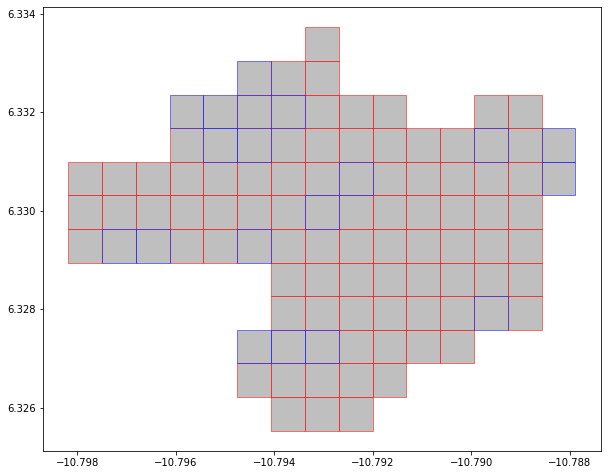

In [10]:
tiles_gdf = proc.train_validation_split(tiles_df,valid_set_size=.2, visualize=True)

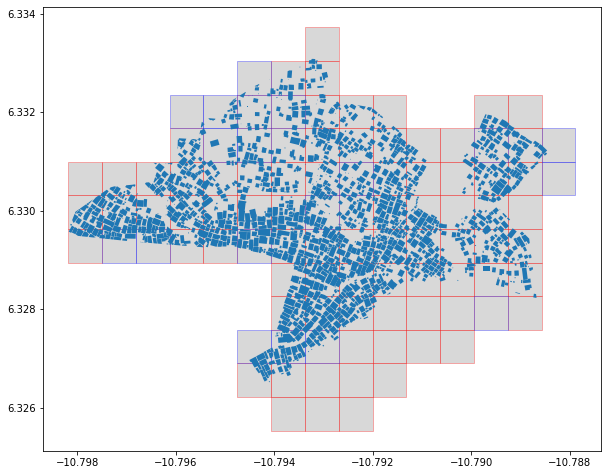

In [11]:
# Visualize the tiles over the polygons
vis.visualize_burned_cells(tiles_gdf, label_gdf)

In [12]:
#create xyz column 
tiles_gdf = proc.reformat_xyz(tiles_gdf)

### Load/crop COGtiff  to the area of a sinlge burned tile



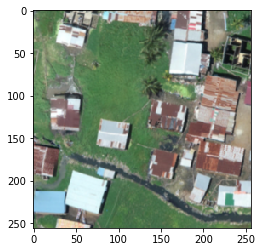

In [13]:
#define tile size. here we will use 256x256 pixel 
tile_size = 256

#Choose a random tile's id:
idx = 30

#clip the tile
tile, mask = rt_main.tile(geotif, *tiles_gdf.iloc[idx]['xyz'], tilesize=tile_size)

#display the clipped COGtif
plt.imshow(np.moveaxis(tile,0,2))

### Crop the label polygons to the area of the same tile

In [14]:
# get the geometries from the geodataframe
all_polys_series = label_gdf.geometry
# preemptively fix and merge any invalid or overlapping geoms that would otherwise throw errors during the rasterize step. 
all_polys_series = proc.cleanup_invalid_geoms(all_polys_series)

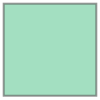

In [15]:
# get the same tile polygon as our tile image above

tile_poly = proc.get_specific_tile(idx = idx, tiles_gdf=tiles_gdf)
tile_poly

In [16]:
#get the Affine Transformation Matrix
tfm = proc.tfm(tile_poly, 256)
tfm

Affine(2.682209014892578e-06, 0.0, -10.794754028320312,
       0.0, -2.6658531825478338e-06, 6.330995309852221)

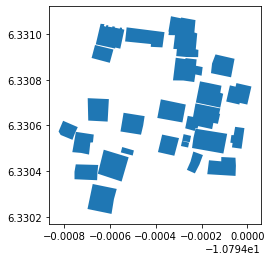

In [17]:
cropped_polys = proc.clip_singletile_polys(idx = idx, tiles_gdf = tiles_gdf, 
                                           all_polys_series= all_polys_series, tile_size = tile_size)



### Use solaris to create a pixel mask

We'll create our corresponding 3-channel RGB mask by passing the cropped polygons to solaris' df_to_px_mask function. 

- 1st (Red) channel represent building footprints,
- 2nd (Green) channel represent building boundaries (visually looks yellow on the RGB mask display because the pixels overlap red and green+red=yellow),
-  3rd (Blue) channel represent close contact points between adjacent buildings

In [18]:
# burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html

fbc_mask = proc.burn_mask(cropped_polys_gdf=cropped_polys, tfm = tfm, tile_size=256, channels=1)

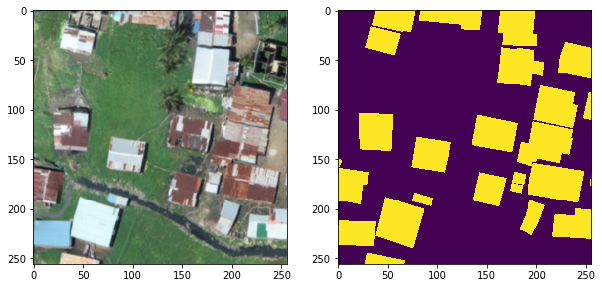

In [19]:
#visualize the new mask next to the COGtiff tile
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.imshow(np.moveaxis(tile,0,2))
ax2.imshow(fbc_mask)

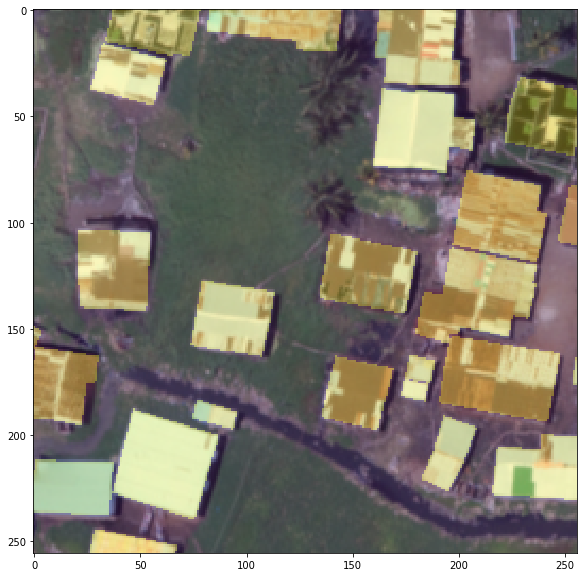

In [20]:
#visualize the new mask overlaying COGtiff tile
fig, ax = plt.subplots( figsize=(10,10))
ax.imshow(np.moveaxis(tile,0,2))
ax.imshow(fbc_mask, alpha = .3)

IndexError: too many indices for array

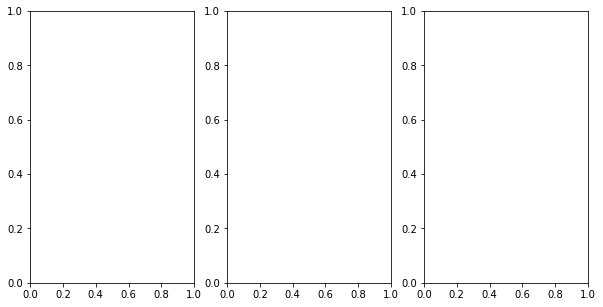

In [22]:
#visualize the 3 bands (footpring, boundary, contact)
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10, 5))
ax1.imshow(fbc_mask[:,:,0])
ax2.imshow(fbc_mask[:,:,1])
ax3.imshow(fbc_mask[:,:,2])

In [30]:
# idx = 14
# tile_poly = proc.get_specific_tile(idx = idx, tiles_gdf=tiles_gdf)
# # tiles_gdf.iloc[idx]['dataset']

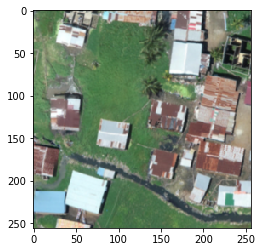

In [34]:
proc.save_tile_img(geotif,xyz=tiles_gdf.iloc[idx]['xyz'], dataset=tiles_gdf.iloc[idx]['dataset'], tile_size=256,
                   zone=zone, region=region, save_path=img_path, display=True)


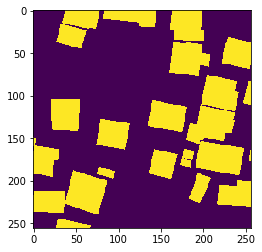

In [35]:

proc.save_tile_mask(all_polys_series, tile_poly, tiles_gdf.iloc[idx]['xyz'], dataset=tiles_gdf.iloc[idx]['dataset'],
                    tile_size=256, zone = zone, region= region, 
                    save_path=mask_path,channels=1, display=True )

### Clip all of the aerial imagery cells, clip all of the polygons, and rasterize all of the labels 

Combine the above process into functions in order to batch process the entire regeion. This will generate the full training and validation sets of Slippy tile cells.

In [36]:
#check the # of tiles that should result from each set:
tiles_gdf[tiles_gdf['dataset'] == 'training'].shape, tiles_gdf[tiles_gdf['dataset'] == 'validation'].shape

((81, 5), (18, 5))

In [37]:
#total number of iterations to expect for the batch processing:
len(tiles_gdf)

99

In [43]:
#batch process the entire COG and save all of the tiles
proc.batch_save_tile_img(tiles_gdf= tiles_gdf, tif= geotif, tile_size=256, zone=zone, 
                         region= region, save_path= img_path)


99it [00:19,  5.05it/s]


In [44]:
#batch process the entire set of polygon labels and save all of the tiles

proc.batch_save_tile_mask(tiles_gdf= tiles_gdf, label_poly_series= all_polys_series, tile_size= 256, region= region,
                         zone= zone, save_path= mask_path, channels=1, display=False)

99it [00:02, 36.29it/s]


### Check that the labels and COG cells saved correctly and that the label masks are burned:

In [45]:
#use glob to put all of the file names into a dataframe for easy access 
df_filepaths = proc.make_filepath_df(region = region,zone = zone, zoom_level = 19)
df_filepaths.head()

,img_path,mask_path
0,../../data/processed/images-256-mon-207cc7-19/...,../../data/processed/masks-256-mon-207cc7-19/m...
1,../../data/processed/images-256-mon-207cc7-19/...,../../data/processed/masks-256-mon-207cc7-19/m...
2,../../data/processed/images-256-mon-207cc7-19/...,../../data/processed/masks-256-mon-207cc7-19/m...
3,../../data/processed/images-256-mon-207cc7-19/...,../../data/processed/masks-256-mon-207cc7-19/m...
4,../../data/processed/images-256-mon-207cc7-19/...,../../data/processed/masks-256-mon-207cc7-19/m...


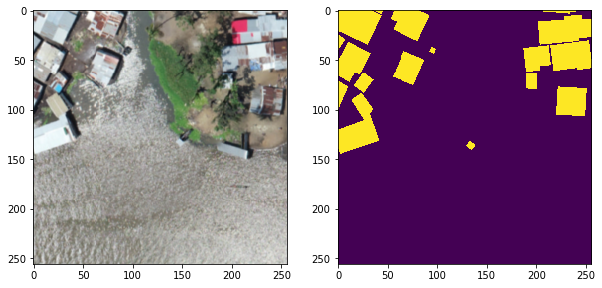

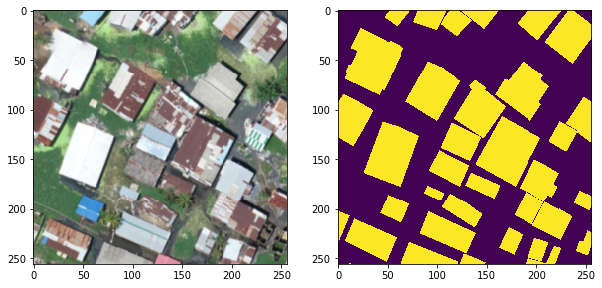

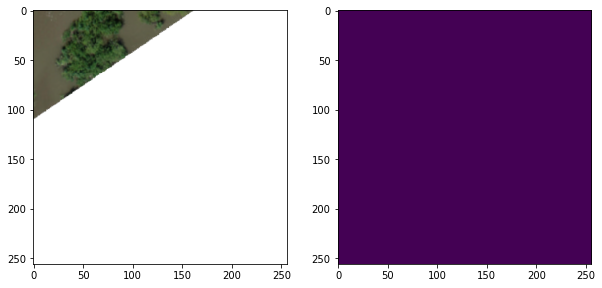

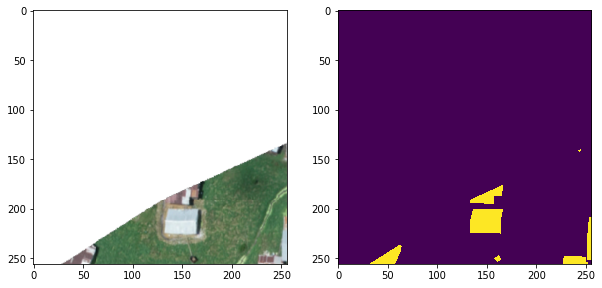

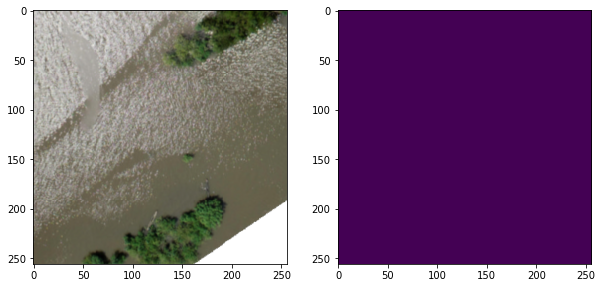

In [46]:
vis.visualize_saved_tiles(5,10, df_filepaths)

In [ ]:
#NOTE: the above region's total cells make up ~53 mb of data: 49 from the COG tiles and 3 from the masks. This makes
# it seem way more possible to just have everything on my local machine. 

#That being said, can mount drive and save all of the tiles to google drive if run the following:

# # compress and download
# !tar -czf znz001trn.tar.gz data

# #save to drive
# from google.colab import drive
# drive.mount('/content/drive')